In [142]:
from pathlib import Path
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

In [206]:
def get_results(path="/mnt/c/github/explainabloomity/results"):
    models = ("opt-13b", )
    prune_methods=(
        "balanced",
        "balanced_mask"
        # "imbalanced" ,
    )
    metrics=(
        "cosine_cosine" ,
        "euclidean_euclidean" ,
        "cosine_random",
        "euclidean_random",
    )
    prunetasks=(
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
    )
    prune_percents=(
        "0.25",
        "0.5",
        "0.75",
    )
    tasks=(
        "lambada_openai",
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
        "blimp_irregular_plural_subject_verb_agreement_1")
    rows = []
    for model in models:
        for prune_method in prune_methods:
            for prune_task in prunetasks:
                for prune_metric in metrics:
                    for task in tasks:
                        for prune_percent in prune_percents:
                            path_model = Path("./results")/ task / model / prune_method / prune_task / prune_metric / prune_percent / "results.json"
                            if path_model.exists():
                                with open(path_model, "r", encoding='utf-8') as f:
                                    data = json.load(f)
                                    norm_accuracy = data["results"][task]["acc,none"]
                                    row = {"model": model, "prune_method": prune_method, "prune_task": prune_task, "metric": prune_metric, "percent": float(prune_percent), "task": task, "norm_accuracy": norm_accuracy}
                                    rows.append(row)
                        base_model = model + "_base"
                        path_model = Path("./results")/ task / base_model / "results.json"
                        if path_model.exists():
                            with open(path_model, "r") as f:
                                data = json.load(f)
                                norm_accuracy = data["results"][task]["acc,none"]
                                row = {"model": model, "prune_method": prune_method, "prune_task": prune_task, "metric": prune_metric, "percent": 0.0, "task": task, "norm_accuracy": norm_accuracy}
                                rows.append(row)

    df = pd.DataFrame(rows)
    return df

def load_amazon_results(directory='results/opt-13b_amazon'):
    rows =[]
    # Directory names are like '0shot_arc_easy', '0shot_hellaswag', etc.
    for dir_name in os.listdir(directory):
        dir_path = os.path.join(directory, dir_name)
        if os.path.isdir(dir_path):
            # File names are like '0shot_25percent', '0shot_50percent', etc.
            for file_name in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file_name)
                try:
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                        # Extract pruning percentage from file name
                        pruning_percent = file_name.split('_')[1].replace('percent', '')
                        # Store data based on dir_name and pruning percent
                        for dataset, metrics in data['results'].items():
                            if 'acc' in metrics:
                                row = {"model": 'opt-13b', 'prune_method': 'amazon', 'prune_task': dir_name, 'metric': 'amazon', 'percent': float(pruning_percent)/100, 'task': dataset, 'norm_accuracy': metrics['acc']}
                                rows.append(row)
                except Exception as e:
                    print(f'Error loading {file_path}: {e}')
    df = pd.DataFrame(rows)
    return df

df = get_results()
df2 = load_amazon_results()

# Combine the two dataframes
df_final = pd.concat([df, df2])

In [207]:
df_final

model prune_method prune_task         metric  percent  \
0   opt-13b     balanced    paws_en  cosine_cosine     0.25   
1   opt-13b     balanced    paws_en  cosine_cosine     0.50   
2   opt-13b     balanced    paws_en  cosine_cosine     0.75   
3   opt-13b     balanced    paws_en  cosine_cosine     0.00   
4   opt-13b     balanced    paws_en  cosine_cosine     0.25   
..      ...          ...        ...            ...      ...   
35  opt-13b       amazon  hellaswag         amazon     0.75   
36  opt-13b       amazon  hellaswag         amazon     0.75   
37  opt-13b       amazon  hellaswag         amazon     0.75   
38  opt-13b       amazon  hellaswag         amazon     0.75   
39  opt-13b       amazon  hellaswag         amazon     0.75   

                                               task  norm_accuracy  
0                                    lambada_openai       0.452164  
1                                    lambada_openai       0.000000  
2                                    lambada_openai       0.000000  
3                                    lambada_openai       0.686784  
4                                           paws_en       0.391500  
..                                              ...            ...  
35                           blimp_ellipsis_n_bar_1       0.438000  
36                                         arc_easy       0.536616  
37                                          lambada       0.002911  
38  blimp_irregular_plural_subject_verb_agreement_1       0.871000  
39                                        hellaswag       0.312687  

[556 rows x 7 columns]

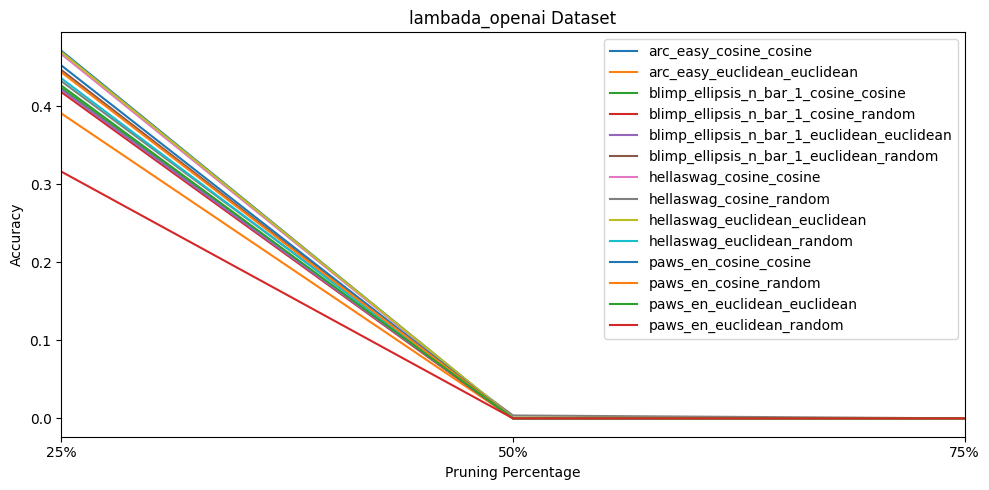

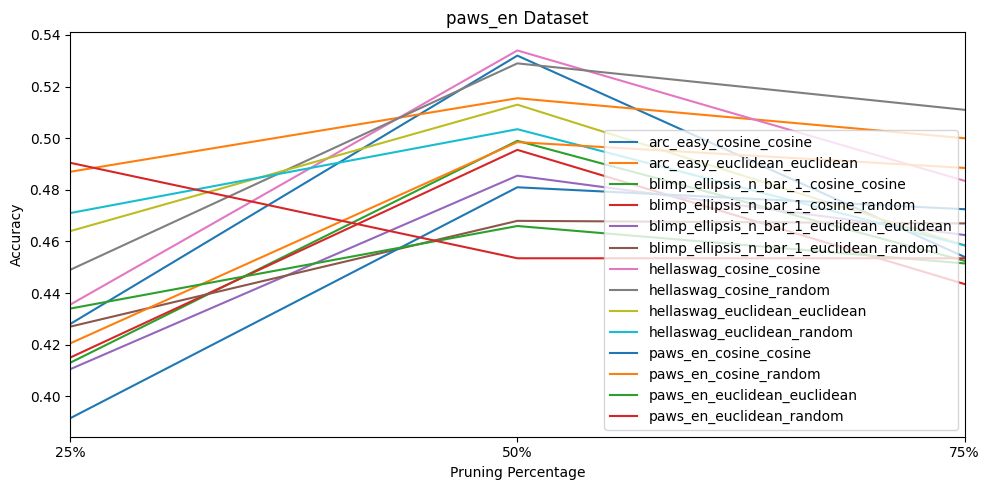

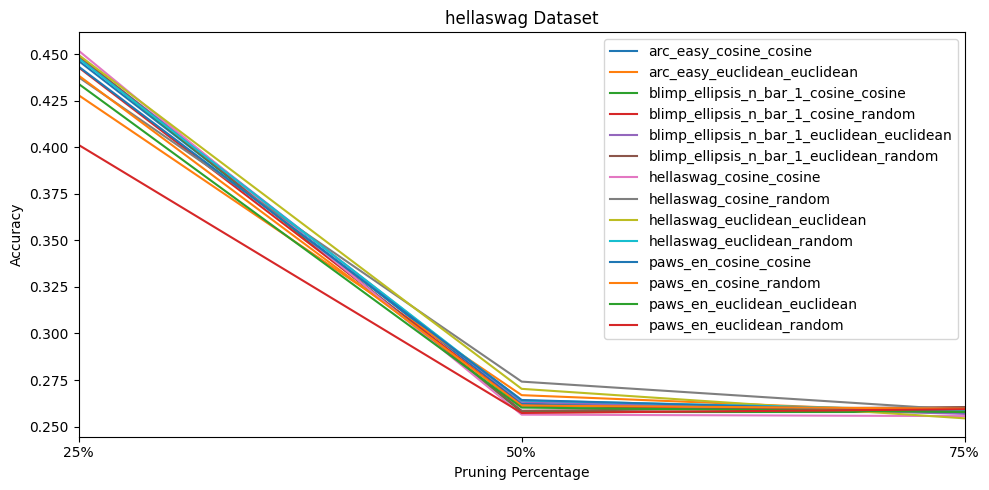

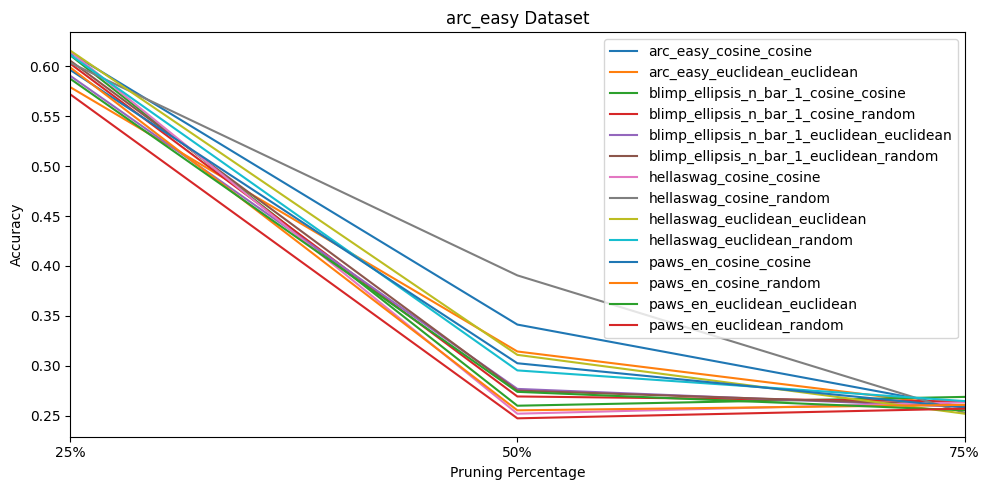

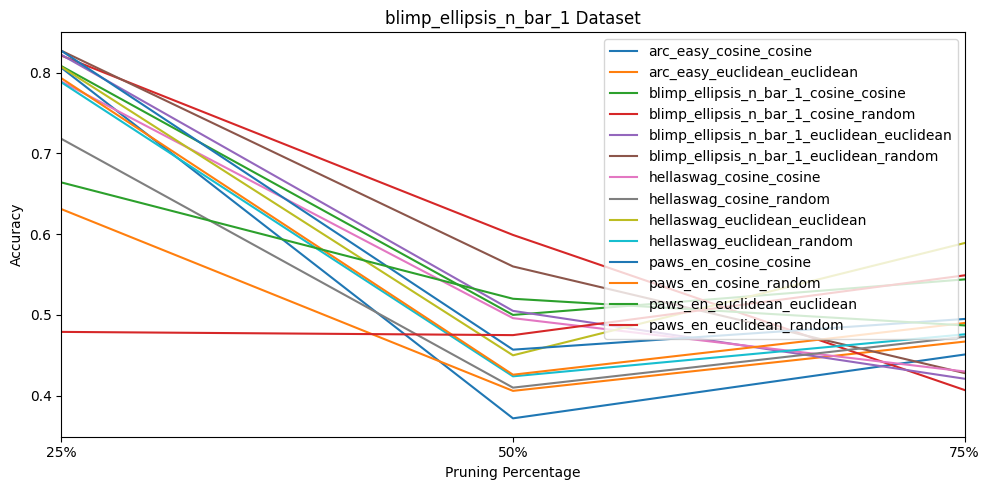

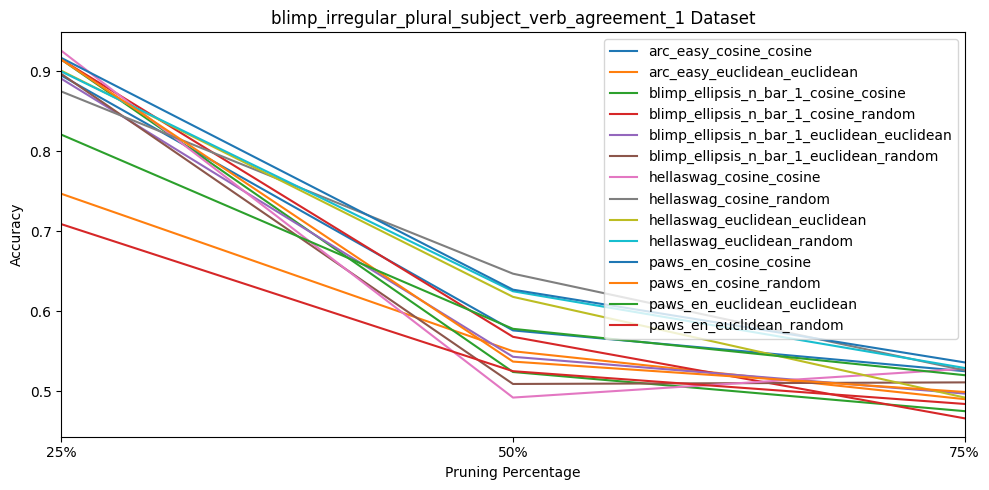

In [103]:
unique_tasks = df['task'].unique()

for task in unique_tasks:
    fig, ax = plt.subplots(figsize=(10, 5))

    task_data = df[df['task'] == task]
    for (prune_task, prune_metric), group_data in task_data.groupby(['prune_task', 'metric']):
        # Creating a unique label for each line
        label = f"{prune_task}_{prune_metric}"
        sorted_data = group_data.sort_values(by='percent')
        ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

    ax.set_title(f'{task} Dataset')
    ax.set_xlabel('Pruning Percentage')
    ax.set_ylabel('Accuracy')
    plt.xticks([0.25, 0.5, 0.75], ['25%', '50%', '75%'])
    # x axis between 0.25 and 0.75
    ax.set_xlim(0.25, 0.75)

    # Creating a legend
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

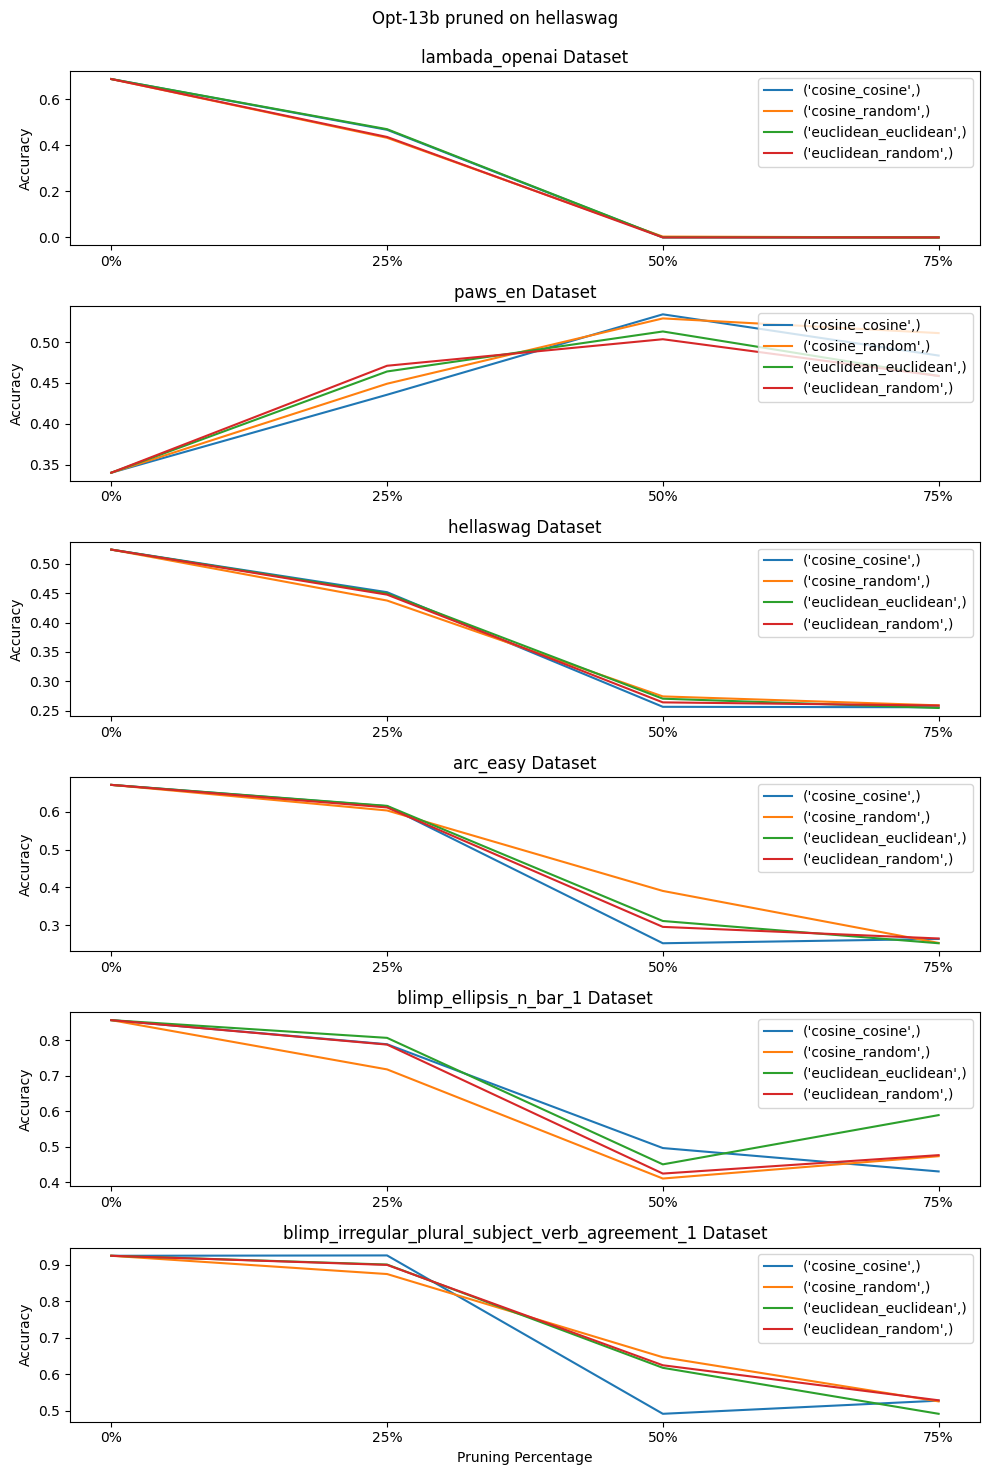

In [132]:
def prune_task_plots(selected_task = 'hellaswag', model='opt-13b'):
    unique_tasks = df['task'].unique()

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        hella = df[df['prune_task'] == selected_task]
        task_data = hella[hella['task'] == task]
        for prune_metric, group_data in task_data.groupby(['metric']):
            # Creating a unique label for each line
            label = prune_metric
            sorted_data = group_data.sort_values(by=['metric','percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')

    fig.suptitle(f'{model.capitalize()} pruned on {selected_task}\n')
    plt.tight_layout()
    plt.show()

prune_task_plots(selected_task='hellaswag', model='opt-13b')

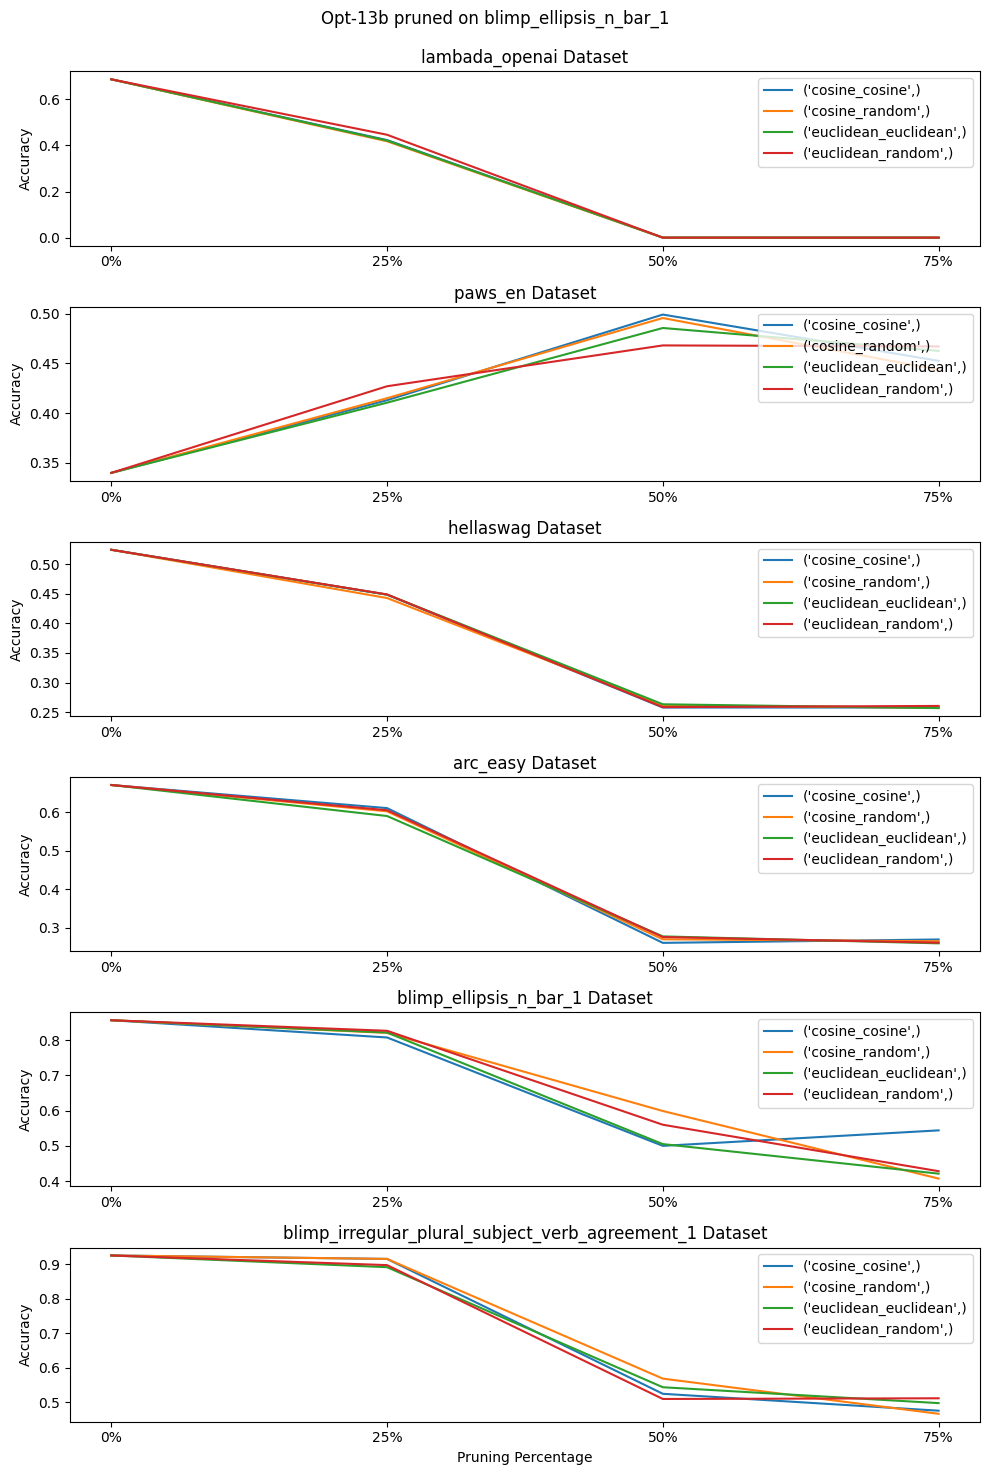

In [133]:
prune_task_plots(selected_task='blimp_ellipsis_n_bar_1', model='opt-13b')

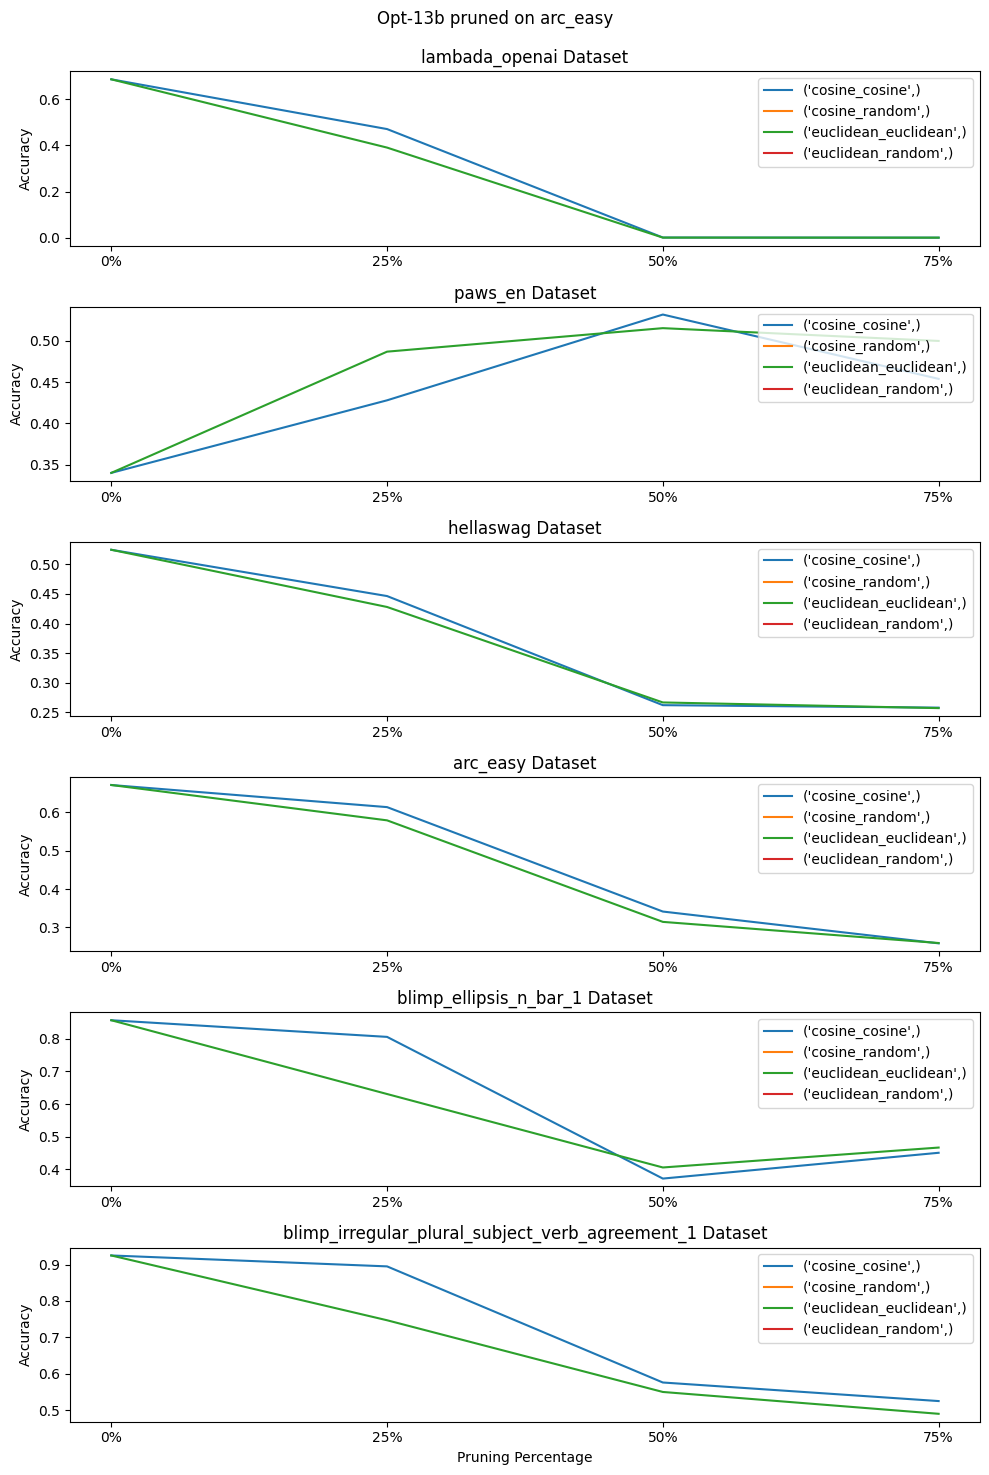

In [134]:
prune_task_plots(selected_task='arc_easy', model='opt-13b')

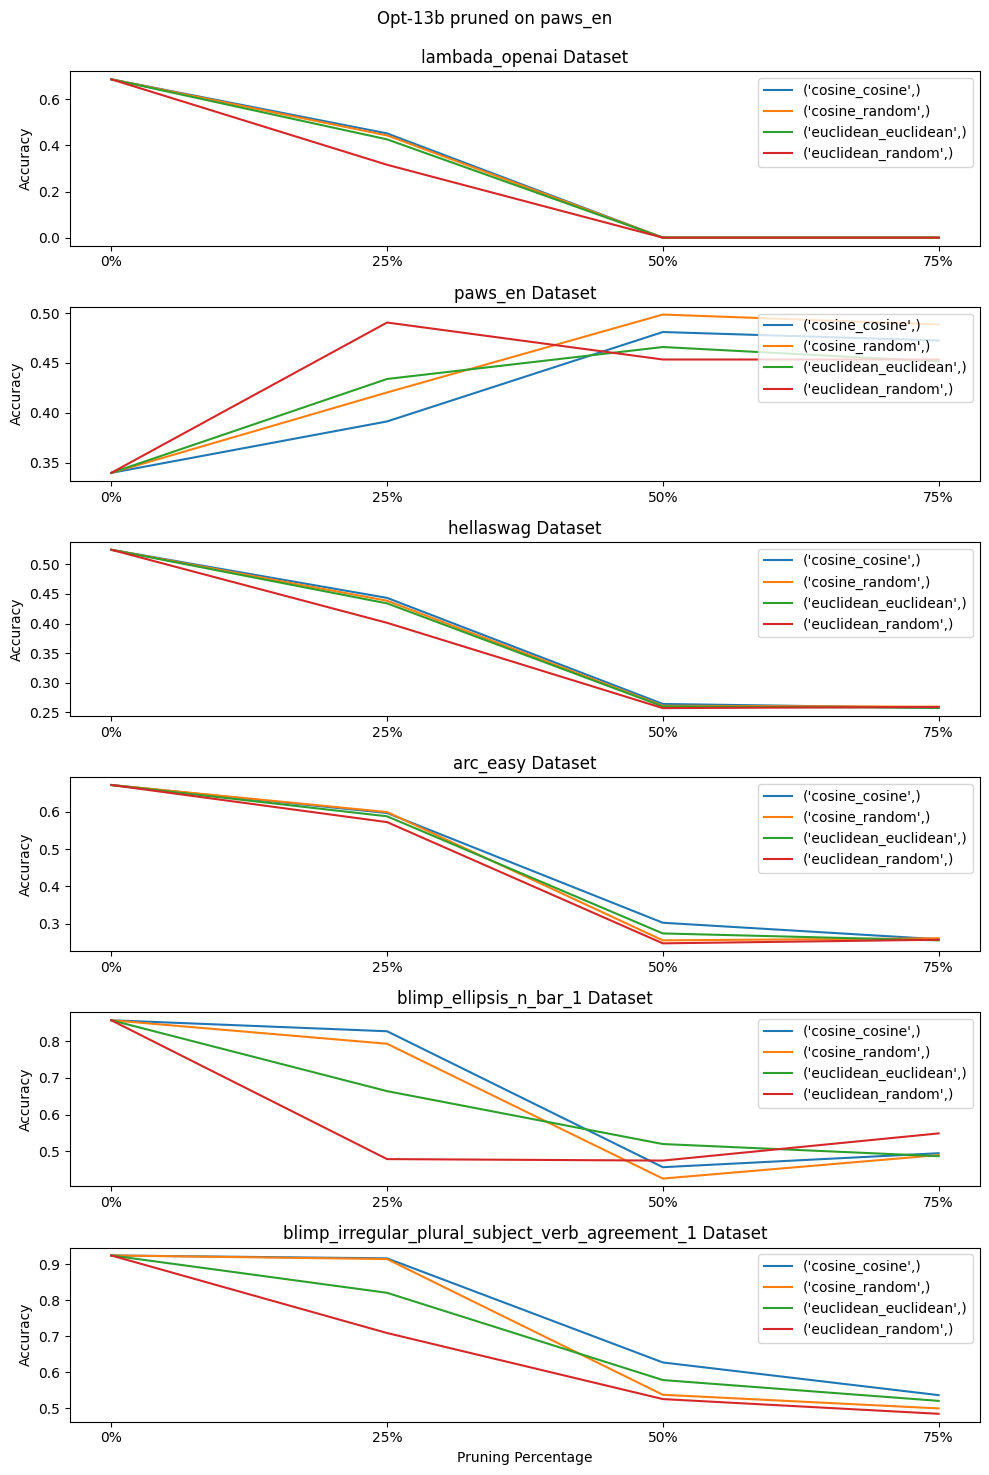

In [135]:
prune_task_plots(selected_task='paws_en', model='opt-13b')

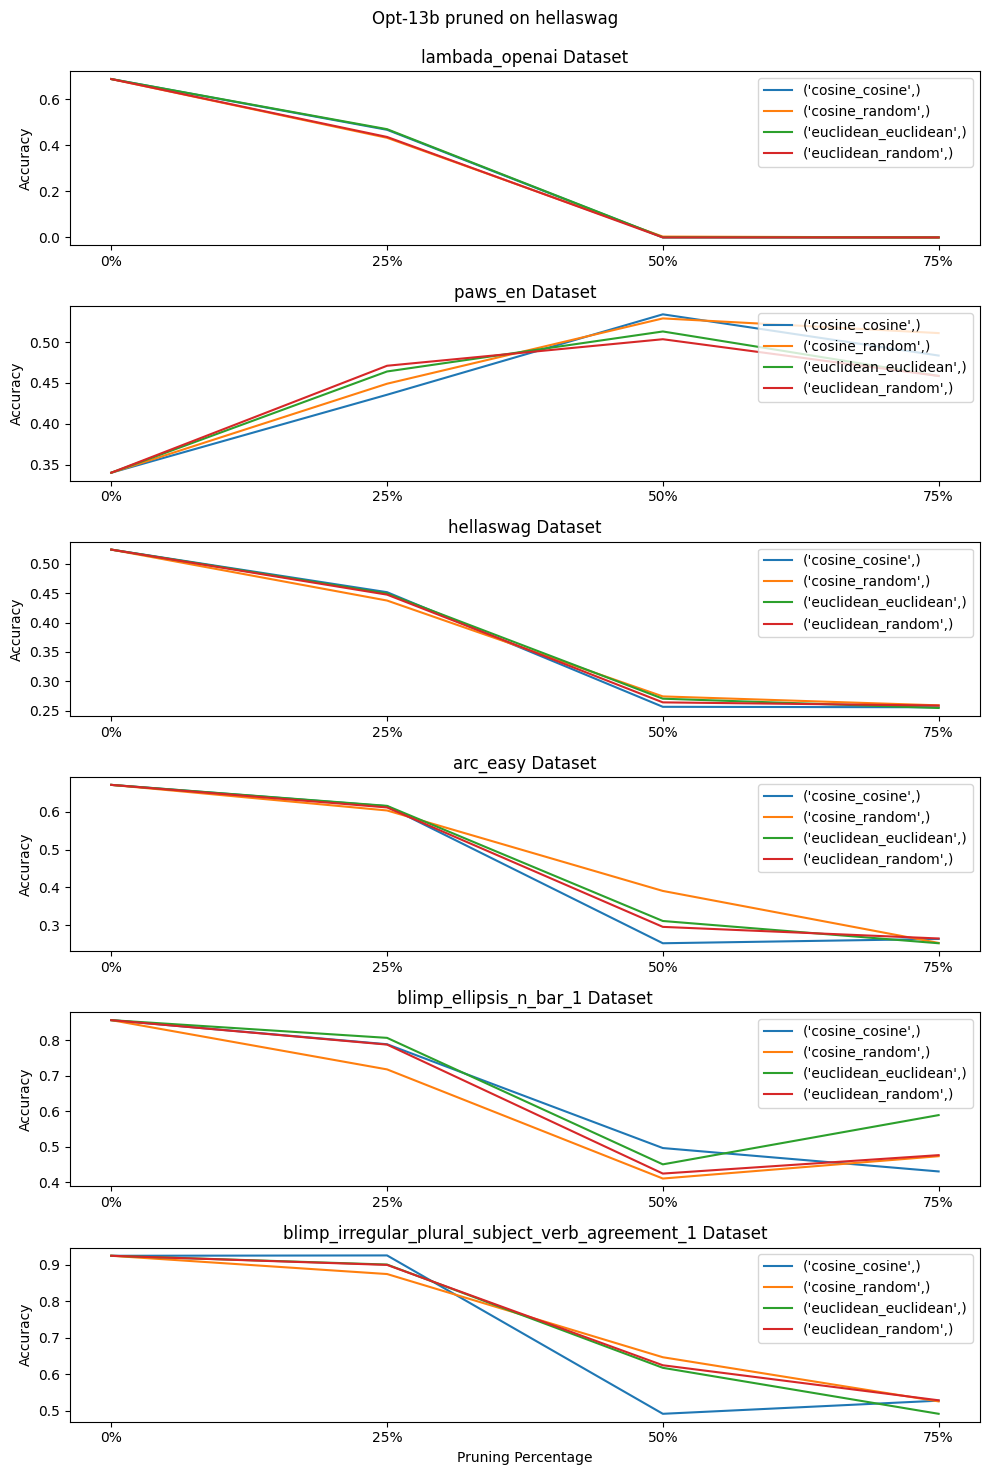

In [146]:
def between_task_plots(df, selected_task = 'hellaswag', model='opt-13b', prune_metric='cosine_cosine'):
    unique_tasks = df['task'].unique()
    df = df[df['metric'] == prune_metric]

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        hella = df[df['prune_task'] == selected_task]
        task_data = hella[hella['task'] == task]
        for prune_metric, group_data in task_data.groupby(['metric']):
            # Creating a unique label for each line
            label = prune_metric
            sorted_data = group_data.sort_values(by=['metric','percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')

    fig.suptitle(f'{model.capitalize()} pruned on {selected_task}\n')
    plt.tight_layout()
    plt.show()

prune_task_plots(selected_task='hellaswag', model='opt-13b')

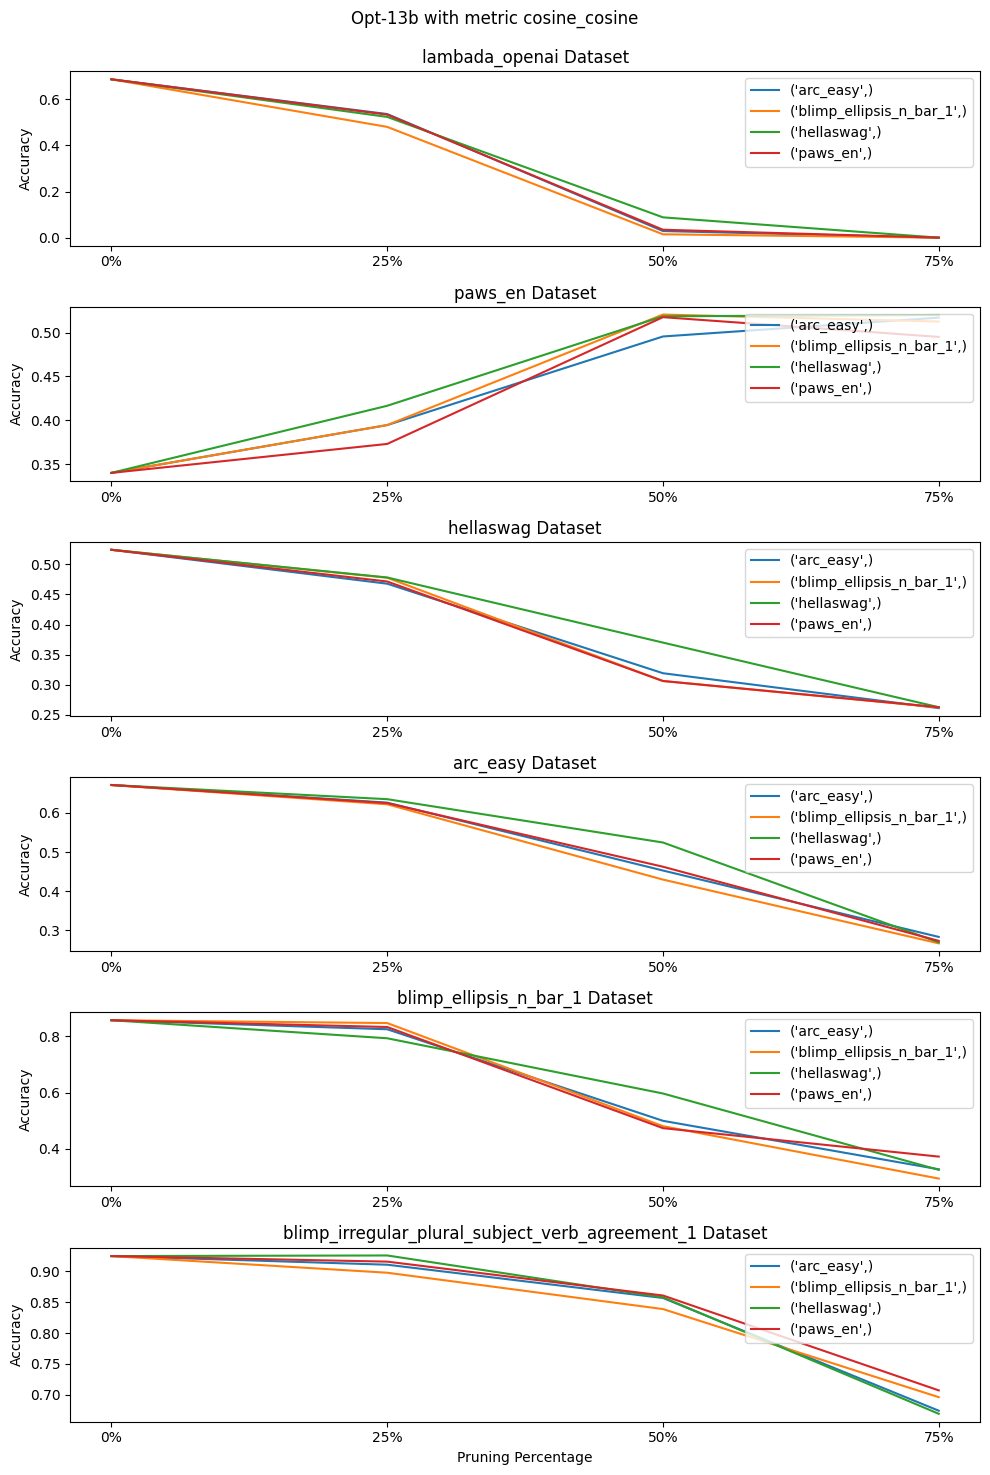

In [173]:
def metric_based_plot(df, prune_metric, model='opt-13b'):
    unique_tasks = df['task'].unique()

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        # Filtering the data based on the selected model and metric
        metric_data = df[(df['metric'] == prune_metric) & (df['model'] == model)]
        task_data = metric_data[metric_data['task'] == task]

        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Creating a unique label for each line
            label = prune_task
            sorted_data = group_data.sort_values(by=['percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')
    fig.suptitle(f'{model.capitalize()} with metric {prune_metric}\n')
    plt.tight_layout()
    plt.show()

metric_based_plot(df[df['prune_method'] == 'balanced_mask'], prune_metric='cosine_cosine', model='opt-13b')

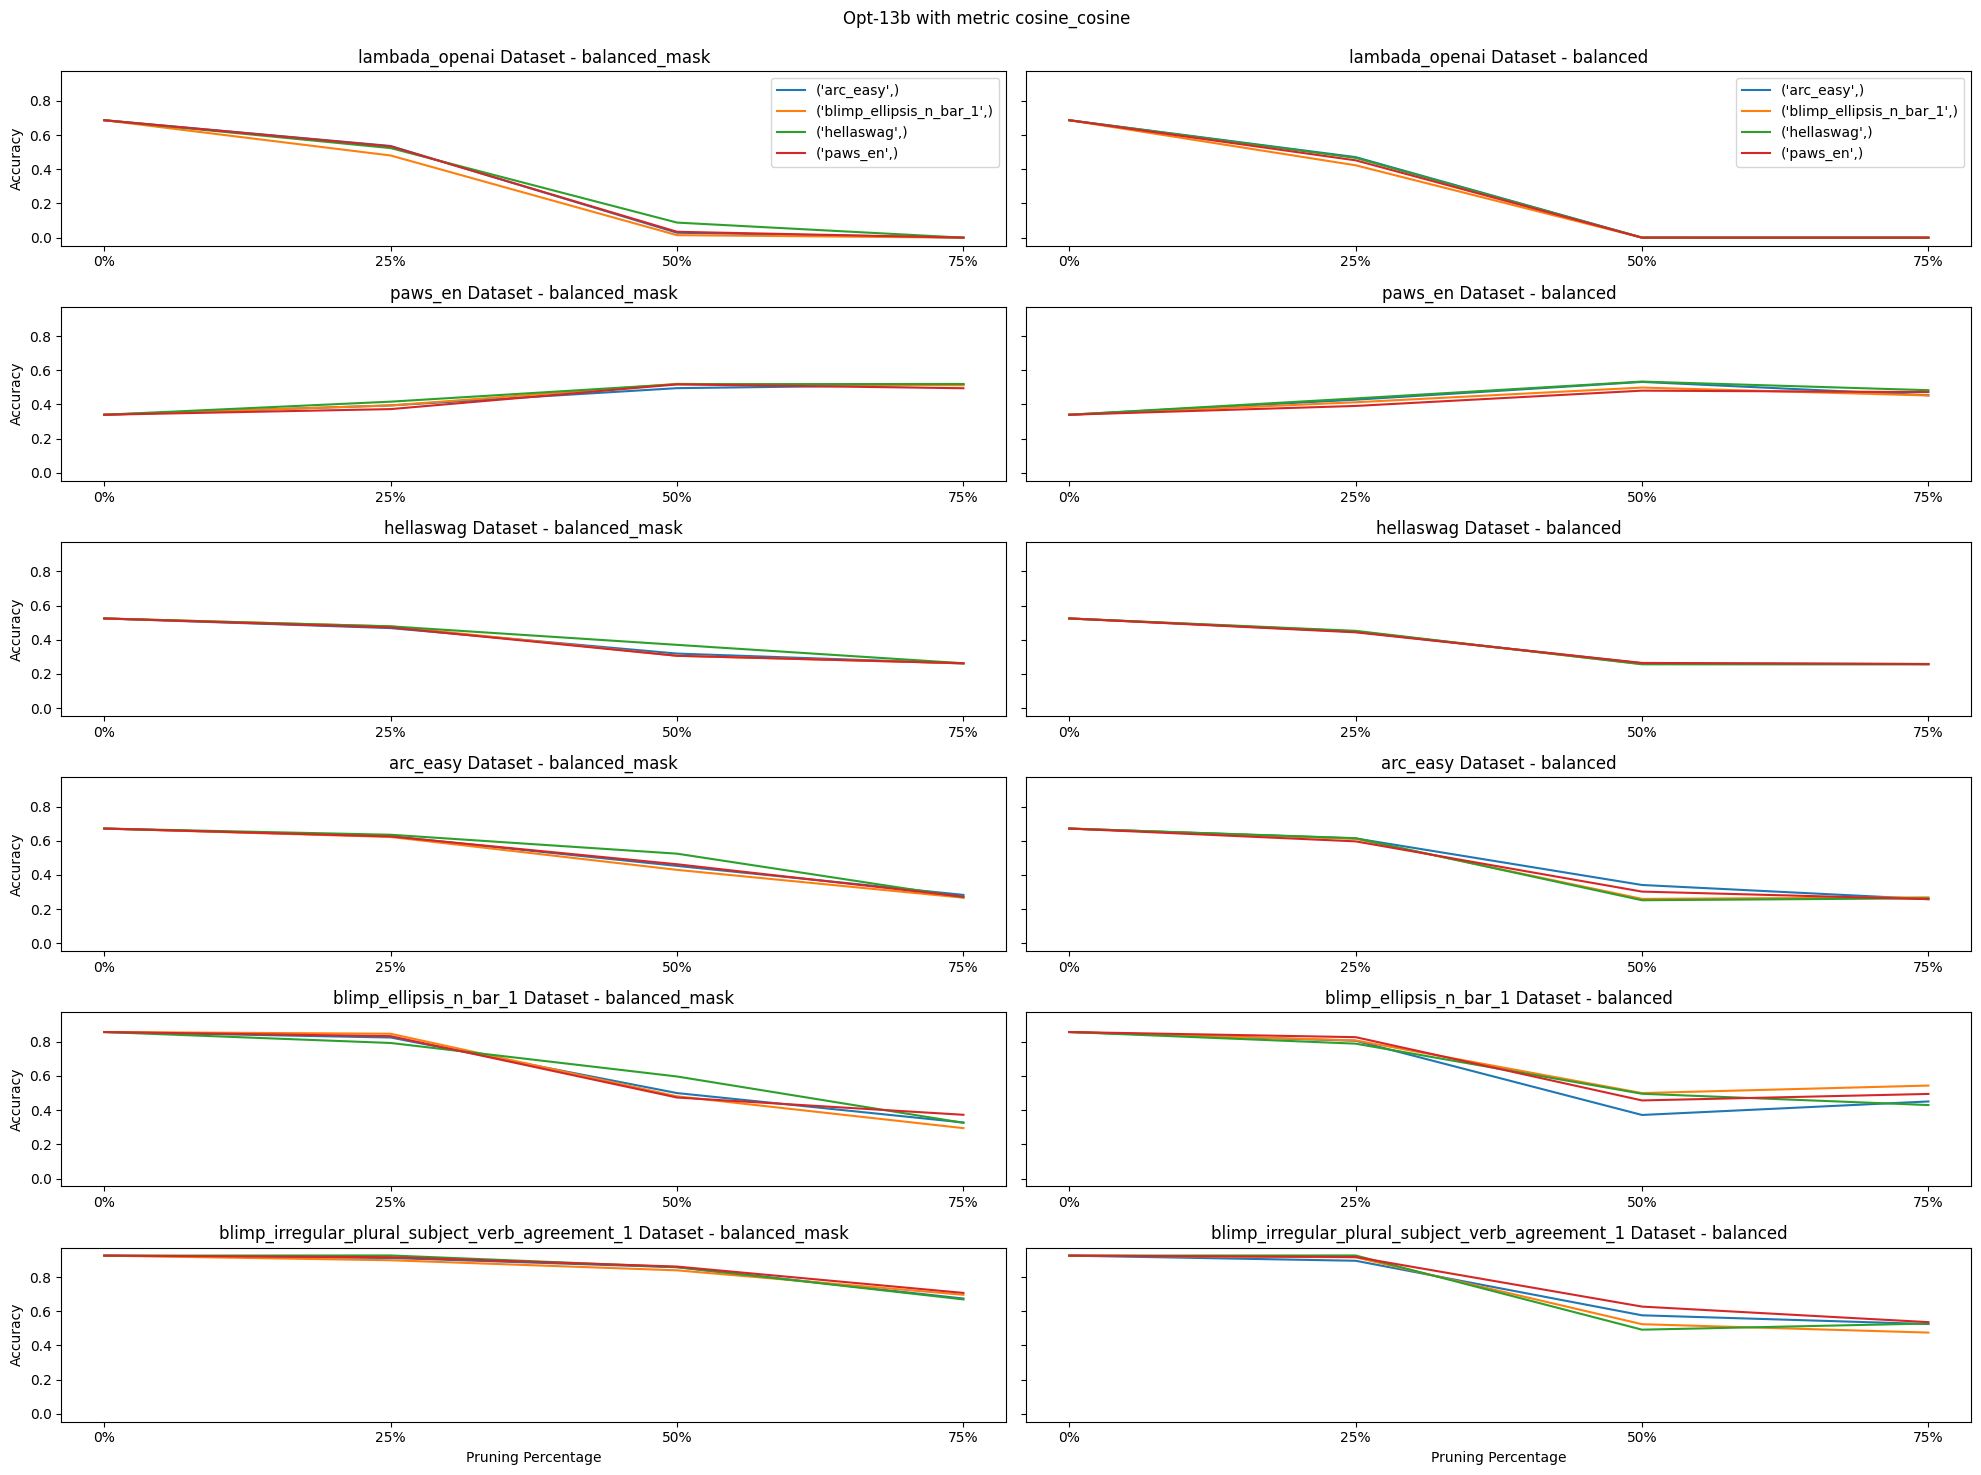

In [174]:
def metric_based_plot(df, prune_metric, model='opt-13b'):
    unique_tasks = df['task'].unique()
    prune_methods = ['balanced_mask', 'balanced']

    # Plotting: 2 columns for the two prune methods, rows as per number of unique tasks
    fig, axes = plt.subplots(len(unique_tasks), 2, figsize=(20, 15), sharey=True)

    for i, task in enumerate(unique_tasks):
        for j, prune_method in enumerate(prune_methods):
            # Filtering the data based on the selected model, metric, and prune method
            metric_data = df[(df['metric'] == prune_metric) & (df['model'] == model) & (df['prune_method'] == prune_method)]
            task_data = metric_data[metric_data['task'] == task]

            for prune_task, group_data in task_data.groupby(['prune_task']):
                # Creating a unique label for each line
                label = prune_task
                sorted_data = group_data.sort_values(by=['percent'])
                axes[i, j].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

            axes[i, j].set_title(f'{task} Dataset - {prune_method}')
            axes[i, j].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])
            if j == 0:
                axes[i, j].set_ylabel('Accuracy')

            if i == 0:
                axes[i, j].legend(loc='upper right')

    axes[-1, 0].set_xlabel('Pruning Percentage')
    axes[-1, 1].set_xlabel('Pruning Percentage')
    fig.suptitle(f'{model.capitalize()} with metric {prune_metric}\n')
    plt.tight_layout()
    plt.show()

# Call the function with the specified metric and model
metric_based_plot(df, prune_metric='cosine_cosine', model='opt-13b')

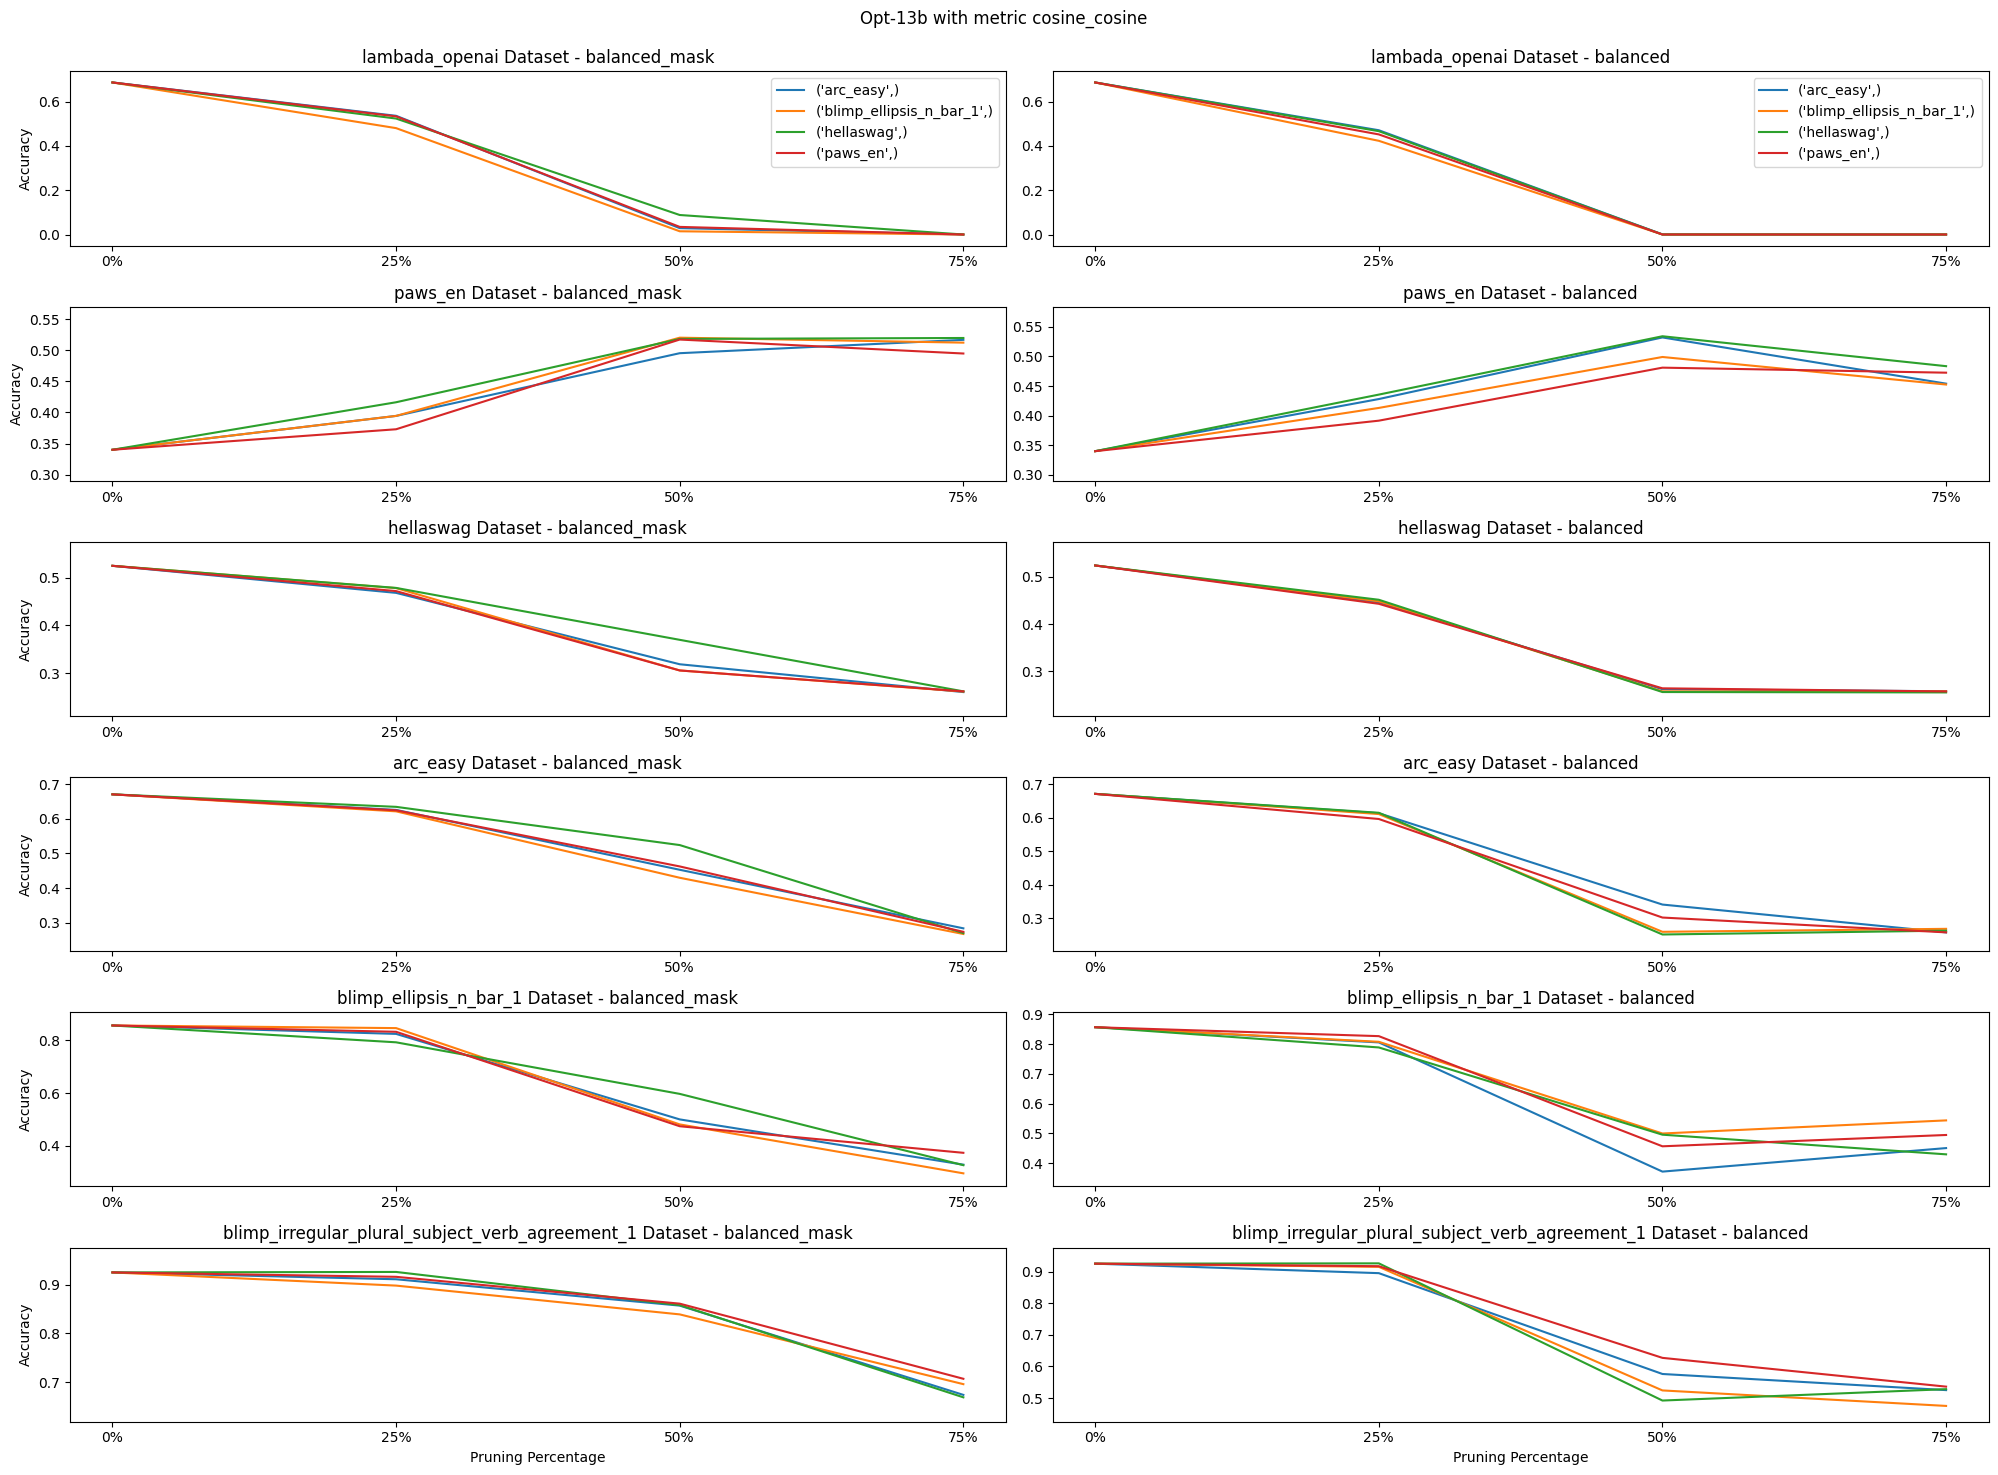

In [175]:
def metric_based_plot(df, prune_metric, model='opt-13b'):
    unique_tasks = df['task'].unique()
    prune_methods = ['balanced_mask', 'balanced']

    # Plotting: 2 columns for the two prune methods, rows as per number of unique tasks
    fig, axes = plt.subplots(len(unique_tasks), 2, figsize=(20, 15))

    for i, task in enumerate(unique_tasks):
        for j, prune_method in enumerate(prune_methods):
            # Filtering the data based on the selected model, metric, and prune method
            metric_data = df[(df['metric'] == prune_metric) & (df['model'] == model) & (df['prune_method'] == prune_method)]
            task_data = metric_data[metric_data['task'] == task]

            if not task_data.empty:
                min_accuracy = task_data['norm_accuracy'].min()
                max_accuracy = task_data['norm_accuracy'].max()

                for prune_task, group_data in task_data.groupby(['prune_task']):
                    # Creating a unique label for each line
                    label = prune_task
                    sorted_data = group_data.sort_values(by=['percent'])
                    axes[i, j].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

                axes[i, j].set_ylim(min_accuracy - 0.05, max_accuracy + 0.05)  # Setting y-axis range

            axes[i, j].set_title(f'{task} Dataset - {prune_method}')
            axes[i, j].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])
            if j == 0:
                axes[i, j].set_ylabel('Accuracy')

            if i == 0:
                axes[i, j].legend(loc='upper right')

    axes[-1, 0].set_xlabel('Pruning Percentage')
    axes[-1, 1].set_xlabel('Pruning Percentage')
    fig.suptitle(f'{model.capitalize()} with metric {prune_metric}\n')
    plt.tight_layout()
    plt.show()

# Call the function with the specified metric and model
metric_based_plot(df, prune_metric='cosine_cosine', model='opt-13b')


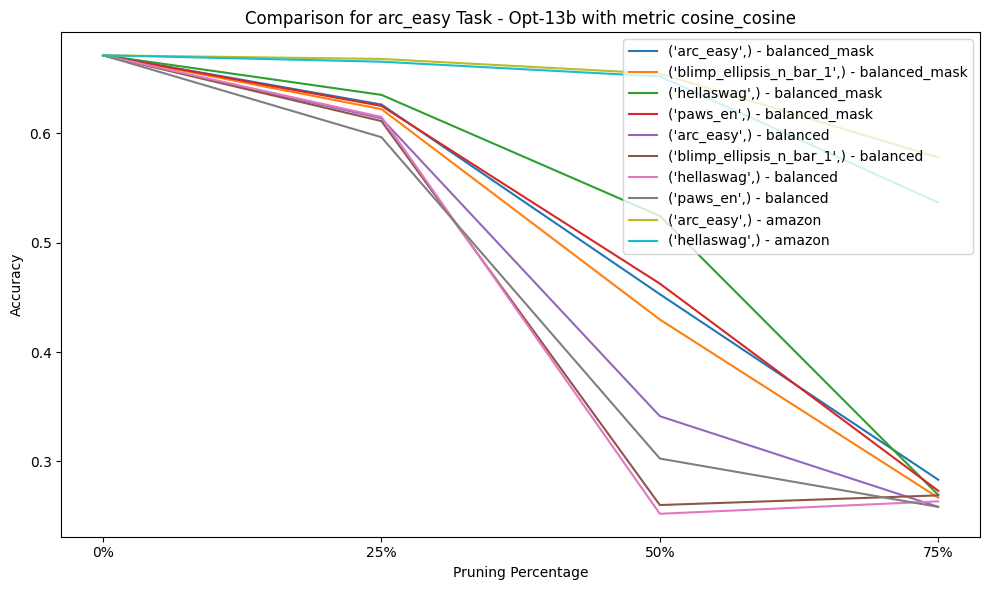

In [215]:
def plot_task_comparison(df, task, prune_metric, model='opt-13b'):
    #df = df[df['prune_task'] == task]
    prune_methods = ['balanced_mask', 'balanced', 'amazon']

    # Initialize the plot
    plt.figure(figsize=(10, 6))

    for prune_method in prune_methods:
        # Filtering data based on task, prune method, metric, and model
        task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                       ((df['metric'] == prune_metric) | (df['metric'] == 'amazon')) & (df['model'] == model)]

        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Sort and plot each group
            sorted_data = group_data.sort_values(by=['percent'])
            plt.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{prune_task} - {prune_method}')

    # Setting plot details
    plt.title(f'Comparison for {task} Task - {model.capitalize()} with metric {prune_metric}')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])
    plt.tight_layout()
    plt.show()

# Call the function for a specific task
plot_task_comparison(df_final, task='arc_easy', prune_metric='cosine_cosine', model='opt-13b')

In [211]:
df_final

model prune_method prune_task         metric  percent  \
0   opt-13b     balanced    paws_en  cosine_cosine     0.25   
1   opt-13b     balanced    paws_en  cosine_cosine     0.50   
2   opt-13b     balanced    paws_en  cosine_cosine     0.75   
3   opt-13b     balanced    paws_en  cosine_cosine     0.00   
4   opt-13b     balanced    paws_en  cosine_cosine     0.25   
..      ...          ...        ...            ...      ...   
35  opt-13b       amazon  hellaswag         amazon     0.75   
36  opt-13b       amazon  hellaswag         amazon     0.75   
37  opt-13b       amazon  hellaswag         amazon     0.75   
38  opt-13b       amazon  hellaswag         amazon     0.75   
39  opt-13b       amazon  hellaswag         amazon     0.75   

                                               task  norm_accuracy  
0                                    lambada_openai       0.452164  
1                                    lambada_openai       0.000000  
2                                    lambada_openai       0.000000  
3                                    lambada_openai       0.686784  
4                                           paws_en       0.391500  
..                                              ...            ...  
35                           blimp_ellipsis_n_bar_1       0.438000  
36                                         arc_easy       0.536616  
37                                          lambada       0.002911  
38  blimp_irregular_plural_subject_verb_agreement_1       0.871000  
39                                        hellaswag       0.312687  

[556 rows x 7 columns]

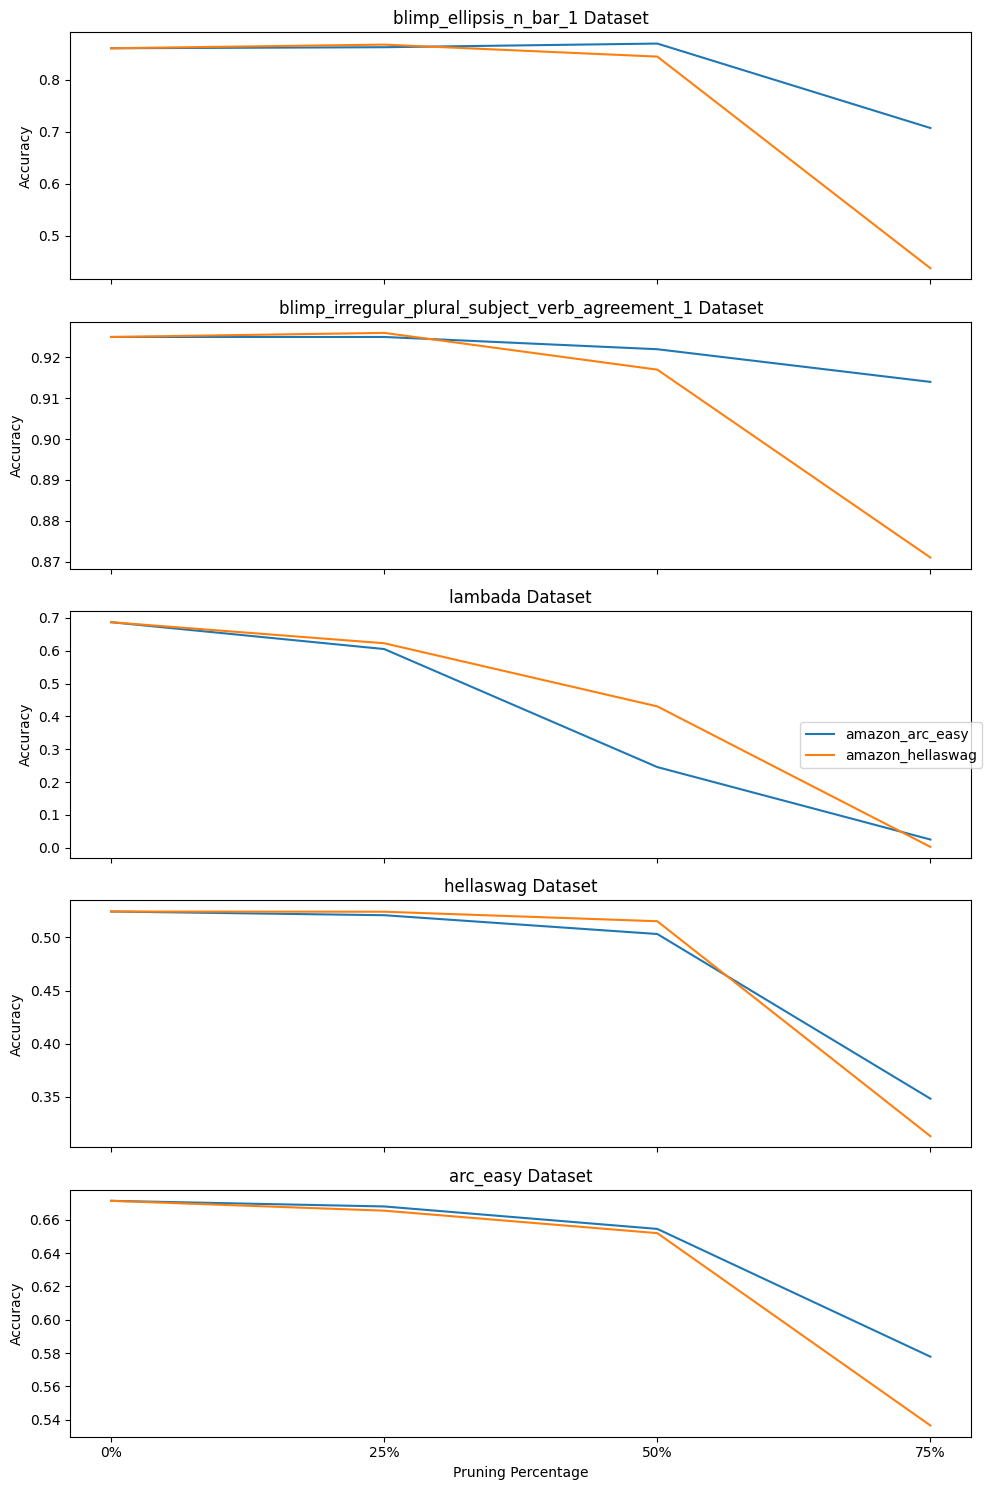

In [189]:
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict

def load_amazon_results(directory):
    all_results = defaultdict(lambda: defaultdict(dict))
    # Directory names are like '0shot_arc_easy', '0shot_hellaswag', etc.
    for dir_name in os.listdir(directory):
        dir_path = os.path.join(directory, dir_name)
        if os.path.isdir(dir_path):
            # File names are like '0shot_25percent', '0shot_50percent', etc.
            for file_name in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file_name)
                try:
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                        # Extract pruning percentage from file name
                        pruning_percent = file_name.split('_')[1].replace('percent', '')
                        # Store data based on dir_name and pruning percent
                        for dataset, metrics in data['results'].items():
                            if 'acc' in metrics:
                                all_results[dataset][dir_name][pruning_percent] = metrics['acc']
                except Exception as e:
                    print(f'Error loading {file_path}: {e}')
    return all_results

# Path to the directory containing the results
results_directory = 'results/opt-13b_amazon'
all_data = load_amazon_results(results_directory)

# Plotting
fig, axes = plt.subplots(len(all_data), 1, figsize=(10, 15), sharex=True)

for i, (dataset, dir_data) in enumerate(all_data.items()):
    for dir_name, pruning_data in dir_data.items():
        label = dir_name.replace('0shot', 'amazon')
        x_values = sorted(pruning_data.keys(), key=lambda x: float(x))
        y_values = [pruning_data[x] for x in x_values]

        # Converting string percentages to float for plotting
        x_values = [float(x)/100 for x in x_values]

        axes[i].plot(x_values, y_values, label=label)

    axes[i].set_title(f'{dataset} Dataset')
    axes[i].set_ylabel('Accuracy')

axes[-1].set_xlabel('Pruning Percentage')
plt.xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

# Creating a unified legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

plt.tight_layout()
plt.show()


In [196]:
df_final

model prune_method       prune_task         metric  percent  \
0   opt-13b     balanced          paws_en  cosine_cosine     0.25   
1   opt-13b     balanced          paws_en  cosine_cosine     0.50   
2   opt-13b     balanced          paws_en  cosine_cosine     0.75   
3   opt-13b     balanced          paws_en  cosine_cosine     0.00   
4   opt-13b     balanced          paws_en  cosine_cosine     0.25   
..      ...          ...              ...            ...      ...   
35  opt-13b       amazon  0shot_hellaswag         amazon    75.00   
36  opt-13b       amazon  0shot_hellaswag         amazon    75.00   
37  opt-13b       amazon  0shot_hellaswag         amazon    75.00   
38  opt-13b       amazon  0shot_hellaswag         amazon    75.00   
39  opt-13b       amazon  0shot_hellaswag         amazon    75.00   

                                               task  norm_accuracy  
0                                    lambada_openai       0.452164  
1                                    lambada_openai       0.000000  
2                                    lambada_openai       0.000000  
3                                    lambada_openai       0.686784  
4                                           paws_en       0.391500  
..                                              ...            ...  
35                           blimp_ellipsis_n_bar_1       0.438000  
36                                         arc_easy       0.536616  
37                                          lambada       0.002911  
38  blimp_irregular_plural_subject_verb_agreement_1       0.871000  
39                                        hellaswag       0.312687  

[556 rows x 7 columns]